Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos
<br>

<center>
    <h2> Tarea 3 </h2>
    <h1> Regresión Logistica y GMM </h1>
    <p>
        Profesor Marcelo Mendoza<br>
        Primer Semestre 2023<br>    
        Fecha de entrega: Miércoles  26 de Abril
    </p>
    <br>
</center>

<br>

---

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas. 

**IMPORTANTE**: 
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas. Es decir, si tienes un código perfecto pero este no es explicado o no se responden preguntas asociadas a este, no se tendrá el puntaje completo.
- El notebook debe tener todas las celdas de código ejecutadas. Cualquier notebook que no las tenga no podrá ser corregido.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## Librerías

In [532]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

## Utils

In [533]:
def min_var(v,exp_var):
    acc = 0
    i=0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i

In [534]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues, plt=plt.gca()):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     fig = plt.get_figure()
#     im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.set_title(title)
#     tick_marks = np.arange(len(classes))
#     plt.set_xticks(tick_marks, classes, rotation=90)
#     plt.set_yticks(tick_marks, classes)
#     plt.grid(False)
#     fig.colorbar(im, ax=plt)
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.set_ylabel('True label')
#     plt.set_xlabel('Predicted label')

In [535]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Parte 1: Carga y Preprocesamiento de Datos
En esta tarea deberás trabajar con el dataset de Credit Card Fraud que puedes descargar de [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

### 1.1 Carga de Datos

In [536]:
dframe = pd.read_csv("creditcard.csv", encoding = "ISO-8859-1")

### 1.2 Descripción del dataset (2 pts.)
Investiga sobre el dataset y responder las siguientes preguntas:
- ¿En que consiste el dataset?
- ¿Que significan las variables?
- ¿Por que el dataset presenta las variables en la forma que lo hace?
- ¿Hay algo que te llame la atencion? (Hint: revisa la cantidad de datos por clase)

### 1.3 Preprocesamiento (2 pts.)
Una vez tengas claro en que consisten los datos debes prepararlos para ser usados. Realiza el preprocesamiento necesario, esto puede incluir remoción de valores nulos y outliers, normalización, entre otros. Es importante que cada paso sea justificado correctamente. 

In [537]:
dframe.dropna(inplace=True)
dframe[dframe.isnull().any(axis=1)].size
x_df = dframe.drop(['Time', 'Amount', 'Class'], axis=1)

vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(x_df.to_dict("records"))
X2 = vectorizer.fit_transform(x_df.to_dict("records"))

y = dframe.Class.values
classes = np.unique(y)

#### 1.3.1 Train-test split (1 pt.)
Divide el dataset en conjuntos de training y de test. Usa el 70% de los datos para training y 30% para test.

In [538]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)

## Parte 2: Regresión Logistica V1 (5 pts.)
Ahora que tienes los datos listos, entrena un clasificador de regresion logistica, evalua el modelo utilizando:
- Matriz de Confusión
- Accuracy
- Precision
- Recall

y comenta los resultados. Preguntas guia: 
- ¿Son estos resultados buenos?
- ¿El clasificador se comporta como queremos que lo haga?

In [539]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.999133925541004

In [540]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85289
           1       0.88      0.60      0.71       154

    accuracy                           1.00     85443
   macro avg       0.94      0.80      0.86     85443
weighted avg       1.00      1.00      1.00     85443



Normalized confusion matrix


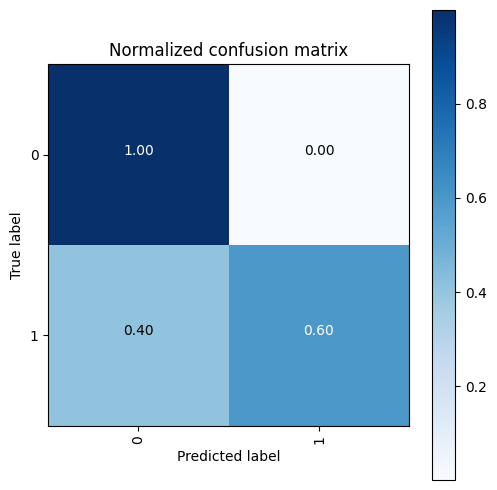

In [541]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

# Parte 3: GMM (10 pts.)
Es posible que en el caso anterior no hayas llegado a un tan buen resultado. Puede que la causa de eso sea el desbalance de clases en el dataset. Para arreglar el desbalance debes utilizar Gaussian Mixture Models. En esta parte tendras que:
- Ajustar una GMM de forma tal que permita arreglar el desbalance del dataset. Los parametros del modelo deben ser justificados.
- Generar datos desde la GMM e incorporarlos al dataset original.
- Para evaluar de forma cualitativa, debes usar PCA para reducir la dimensionalidad de los datos a 2 dimensiones, asi podras graficar los datos originales y los generados.
- Generar un nuevo set de datos de training y testing (70/30).

In [542]:
dframeGMM = pd.read_csv("creditcard.csv", encoding = "ISO-8859-1")
df_frauds = dframeGMM[dframeGMM['Class'] == 1]

In [543]:
df_frauds.dropna(inplace=True)
x_frauds = df_frauds.drop(['Time', 'Amount', 'Class'], axis=1)

vectorizer = DictVectorizer(sparse=False)
X_frauds = vectorizer.fit_transform(x_frauds.to_dict("records"))

C:\Users\javie\AppData\Local\Temp\ipykernel_14052\2859390786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frauds.dropna(inplace=True)


In [544]:
n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_frauds) for n in n_components]

In [545]:
aics = np.asarray([m.aic(X_frauds) for m in models])
np.where(aics == np.amin(aics))[0][0]

28

In [546]:
gmm = GaussianMixture(n_components=28, covariance_type="full")
gmm.fit(X_frauds)
print(gmm.converged_)

True


In [547]:
data_new = gmm.sample(5000)
print(X_frauds)

[[-2.31 -2.77  3.2  ... -2.54  1.39 -2.77]
 [-3.04 -0.84 -0.41 ...  0.33 -0.07 -0.27]
 [-2.3  -1.53  2.03 ...  0.56 -0.4  -0.24]
 ...
 [-0.68 -3.46  1.79 ... -2.23  1.21 -0.65]
 [-3.11 -5.25  1.93 ... -2.21  1.06 -1.63]
 [ 1.99 -0.89  0.49 ...  0.22 -0.07  0.58]]


In [548]:
X_gmm = np.concatenate((X, data_new[0]), axis=0)
X_gmm.shape

y_gmm = np.concatenate((y, np.ones(5000)))

X_gmm.shape

(289807, 28)

Se creo un modelo de GMM a partir de los fraudes del dataset, para asi lograr crear una cantidad de estos que equilibren el desbalanceo del dataset.

In [549]:
pca = PCA(n_components=2)
frauds_pca = pca.fit_transform(X_frauds)
new_frauds_pca = pca.fit_transform(data_new[0])

In [550]:
X_gmm.shape

(289807, 28)

In [551]:
# fig, ax = plt.subplots()

# for index, position in enumerate(X_gmm_pca):
#     x, y = position
#     color = "blue"
#     if index > 284807:
#         color = "red"
#     ax.scatter(x, y, c=color, label=color, alpha=0.3, edgecolors='none')


# ax.legend()
# ax.grid(True)

# plt.show()

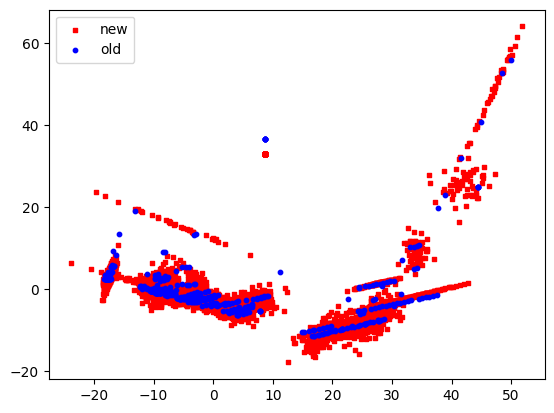

In [552]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(new_frauds_pca[:, 0], new_frauds_pca[:, 1], s=10, c='r', marker="s", label='new')
ax1.scatter(frauds_pca[:, 0],frauds_pca[:, 1], s=10, c='b', marker="o", label='old')
plt.legend(loc='upper left')
plt.show()

#### Responde:
- ¿Por qué un desbalance de clases puede ser perjudicial para el clasificador?
- Analiza el grafico generado con PCA, ¿los datos generados se ven utiles?

## Parte 4: Regresión Logistica V2 (10 pts.)
Finalmente debes entrenar denuevo el clasificador, pero esta vez utilizando el nuevo dataset con datos generados. Repite los mismos pasos que en la Parte 2, en esta parte debes obtener al menos un 85% de accuracy en ambas clases por separado. 

Responde:
- ¿Hubo mejoría en los resultados? Recuerda basarte en accuracy, precision y recall para justificar.
- Si no hubo cambios, identifica que paso o pasos desde el preprocesamiento hasta el entrenamiento de la parte 1 es/son los que hacen la diferencia entre un buen y un mal resultado. ¿Por que los pasos que lograste identificar son importantes?
- Si hubo cambios, mejora los pasos desde el preprocesamiento hasta el entrenamiento de la parte 1 para que obtengas resultados parecidos a la parte 4. ¿Por que estos pasos fueron importantes para mejorar el resultado de la parte 1?

In [553]:
X_train, X_test, y_train, y_test = train_test_split(X_gmm, y_gmm, train_size=0.7, test_size=0.3)

In [554]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9961699044201373

In [555]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85269
         1.0       0.98      0.82      0.89      1674

    accuracy                           1.00     86943
   macro avg       0.99      0.91      0.95     86943
weighted avg       1.00      1.00      1.00     86943



In [556]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    199046
         1.0       0.97      0.81      0.89      3818

    accuracy                           1.00    202864
   macro avg       0.99      0.91      0.94    202864
weighted avg       1.00      1.00      1.00    202864



In [557]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [86943, 202864]